In [40]:
import datetime
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape


np.random.seed(42)
warnings.simplefilter('ignore')

## Step 1: Data preprocessing

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).


In [2]:
data_path = 'owid-covid-data.csv'
df = pd.read_csv(data_path).query("""
    location == 'Russia'\
    and date >= '2020-03-03'
    """)
df.new_cases = df.new_cases.apply(lambda x: 1 if x == 0 else x)
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
122590,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
122591,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
122592,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
122593,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
122594,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


In [3]:
sep_date = str(datetime.datetime.strptime('2020-03-03', '%Y-%m-%d').date()\
               + datetime.timedelta(days=49))
print(f'Last day of train: {sep_date}')

Last day of train: 2020-04-21


## Step 2: First Approximation

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

- Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.
- Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).
- Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


In [4]:
df_ = df[['date', 'total_cases', 'new_cases']]\
        .sort_values('date')\
        .reset_index(drop=True)
df_['day_number'] = [i + 1 for i in range(df_.shape[0])]
print(f'Shape: {df_.shape}')
df_.head()

Shape: (726, 4)


,date,total_cases,new_cases,day_number
0,2020-03-03,3.0,1.0,1
1,2020-03-04,3.0,1.0,2
2,2020-03-05,4.0,1.0,3
3,2020-03-06,13.0,9.0,4
4,2020-03-07,13.0,1.0,5


In [5]:
def plot_dynamics(target: str, df: pd.DataFrame, axline=None, axline_label=None):
    sns.lineplot(data=df,
                 x='date',
                 y=target,
                 label=target)
    if axline:
        plt.axvline(x=axline, label=axline_label, color='red')
    plt.legend()
    plt.xticks(np.arange(0, df.shape[0], step=df.shape[0] // 10), rotation=45)

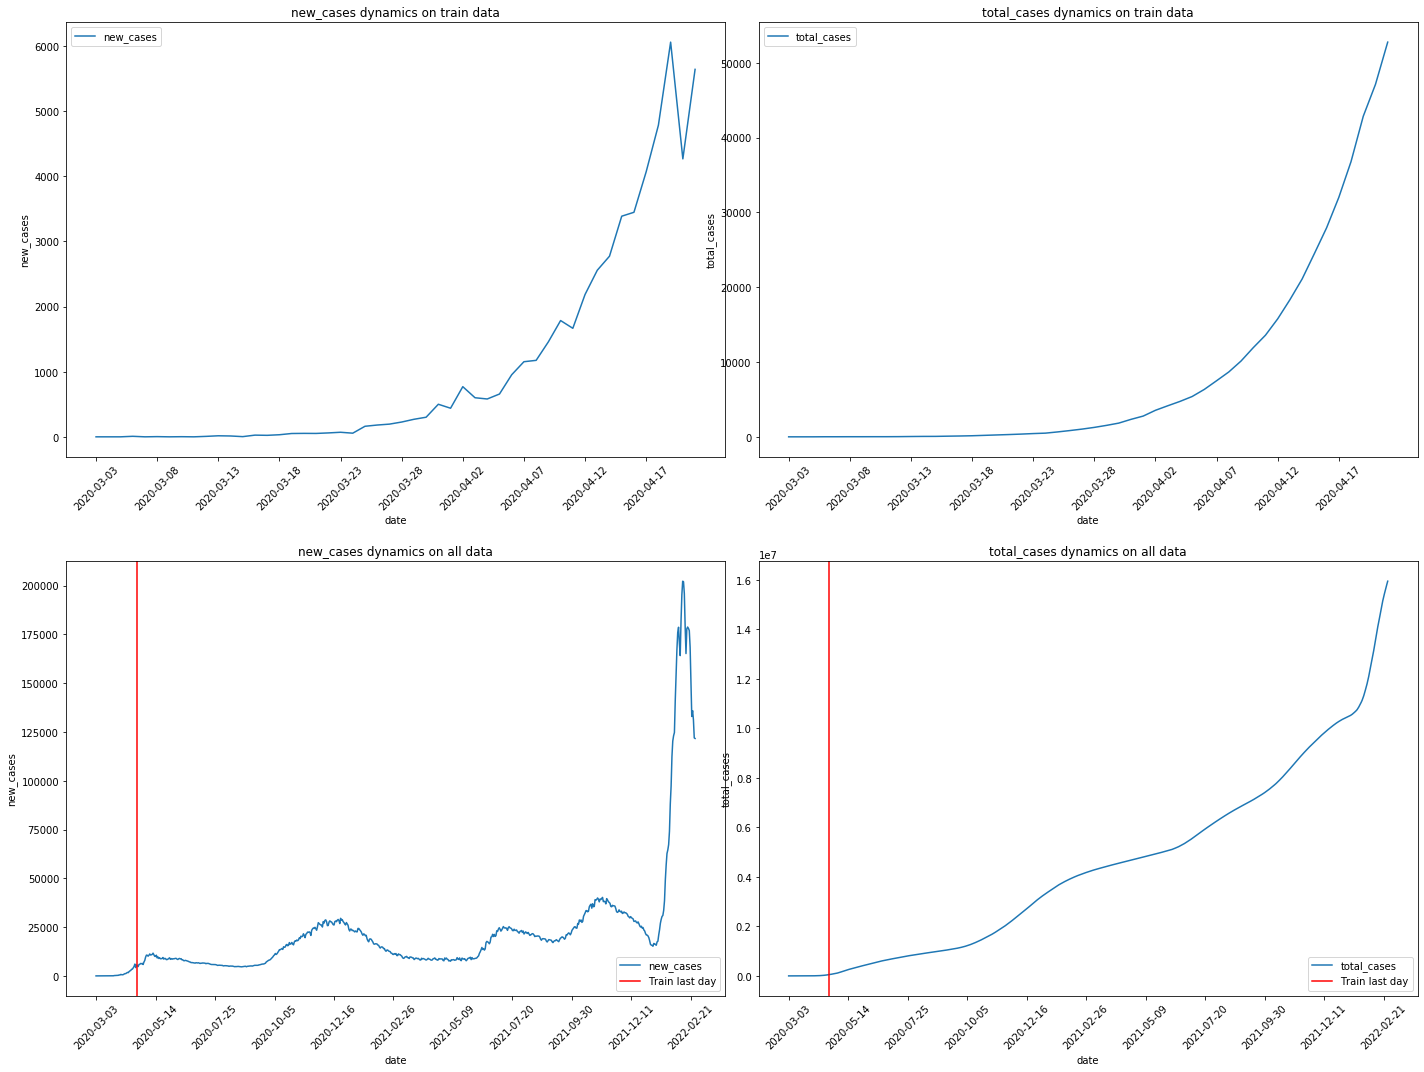

In [6]:
plt.figure(figsize=(20, 15))
plt.tight_layout(h_pad=20)

target = 'new_cases'
plt.subplot(2, 2, 1)
plt.tight_layout(pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(target, df_.query('day_number <= 50'))

plt.subplot(2, 2, 3)
plt.title(f'{target} dynamics on all data')
plot_dynamics(target, df_, sep_date, 'Train last day')


target = 'total_cases'
plt.subplot(2, 2, 2)
plt.tight_layout(h_pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(target, df_.query('day_number <= 50'))

plt.subplot(2, 2, 4)
plt.title(f'{target} dynamics on all data')
plot_dynamics(target, df_, sep_date, 'Train last day')

plt.show()



### Modeling

Для реализации данного алгоритма "y ~ exp(линейная функция от x)" будем строить линейную модель по номеру дня. Как тестовую выборку будем брать дни с 51 по 70. За таргет будем брать натуральный логарифм от total_cases/new_cases

In [7]:
df_modeling = df_.query('day_number <= 70')
df_modeling['dne'] = df_modeling.day_number

In [206]:
# Выбор таргета
target = 'total_cases'

# разделение данных на выборки для обучения
tmp = df_modeling.query('day_number <= 50')
X_train, y_train = tmp[['dne']], np.log(tmp[target])

tmp = df_modeling.query('day_number > 50')
X_test, y_test = tmp[['dne']], np.log(tmp[target])

# Обучение линейной модели
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Предсказание моделей
train_pred = linear_reg.predict(X_train)
test_pred = linear_reg.predict(X_test)

# Вывод результатов
print(f'Target = {target}')
print(f'train MSE: {mse(y_train, train_pred)}')
print(f'test  MSE: {mse(y_test, test_pred)}\n')

print(f'train MAPE: {mape(y_train, train_pred)}')
print(f'test  MAPE: {mape(y_test, test_pred)}\n')


# Сохранение результатов работы модели
df_modeling[f'{target}_prediction'] = list(train_pred) + list(test_pred)

Target = total_cases
train MSE: 0.12183046154391235
test  MSE: 4.29597152693217

train MAPE: 0.07830030388239136
test  MAPE: 0.16394940325136145



In [207]:
# Выбор таргета
target = 'new_cases'

# разделение данных на выборки для обучения
tmp = df_modeling.query('day_number <= 50')
X_train, y_train = tmp[['dne']], np.log(tmp[target])

tmp = df_modeling.query('day_number > 50')
X_test, y_test = tmp[['dne']], np.log(tmp[target])

# Обучение линейной модели
linear_reg = LinearRegression(fit_intercept=True)
linear_reg.fit(X_train, y_train)

# Предсказание моделей
train_pred = linear_reg.predict(X_train)
test_pred = linear_reg.predict(X_test)

# Вывод результатов
print(f'Target = {target}')
print(f'train MSE: {mse(y_train, train_pred)}')
print(f'test  MSE: {mse(y_test, test_pred)}\n')

print(f'train MAPE: {mape(y_train, train_pred)}')
print(f'test  MAPE: {mape(y_test, test_pred)}\n')


# Сохранение результатов работы модели
df_modeling[f'{target}_prediction'] = list(train_pred) + list(test_pred)

Target = new_cases
train MSE: 0.3553090487811398
test  MSE: 6.341190226409629

train MAPE: 525061173249694.3
test  MAPE: 0.2631437021488726



In [10]:
def plot_dynamics(target: str, prediction: str, df: pd.DataFrame, axline=None, axline_label=None):
    sns.lineplot(data=df,
                 x='date',
                 y=target,
                 label=target)
    sns.lineplot(data=df,
                 x='date',
                 y=prediction,
                 label='prediction')
    if axline:
        plt.axvline(x=axline, label=axline_label, color='red')
    plt.legend()
    plt.xticks(np.arange(0, df.shape[0], step=df.shape[0] // 10), rotation=45)

In [16]:
for target in ['new_cases', 'total_cases']:
    # Расчитываем логарифм таргета
    df_modeling[f'log_{target}'] = np.log(df_modeling[target])
    # Расчитываем экспоненту предсказания
    df_modeling[f'exp_{target}_prediction'] = np.exp(df_modeling[f'{target}_prediction'])

График предсказания линейной модели от логарифма таргета


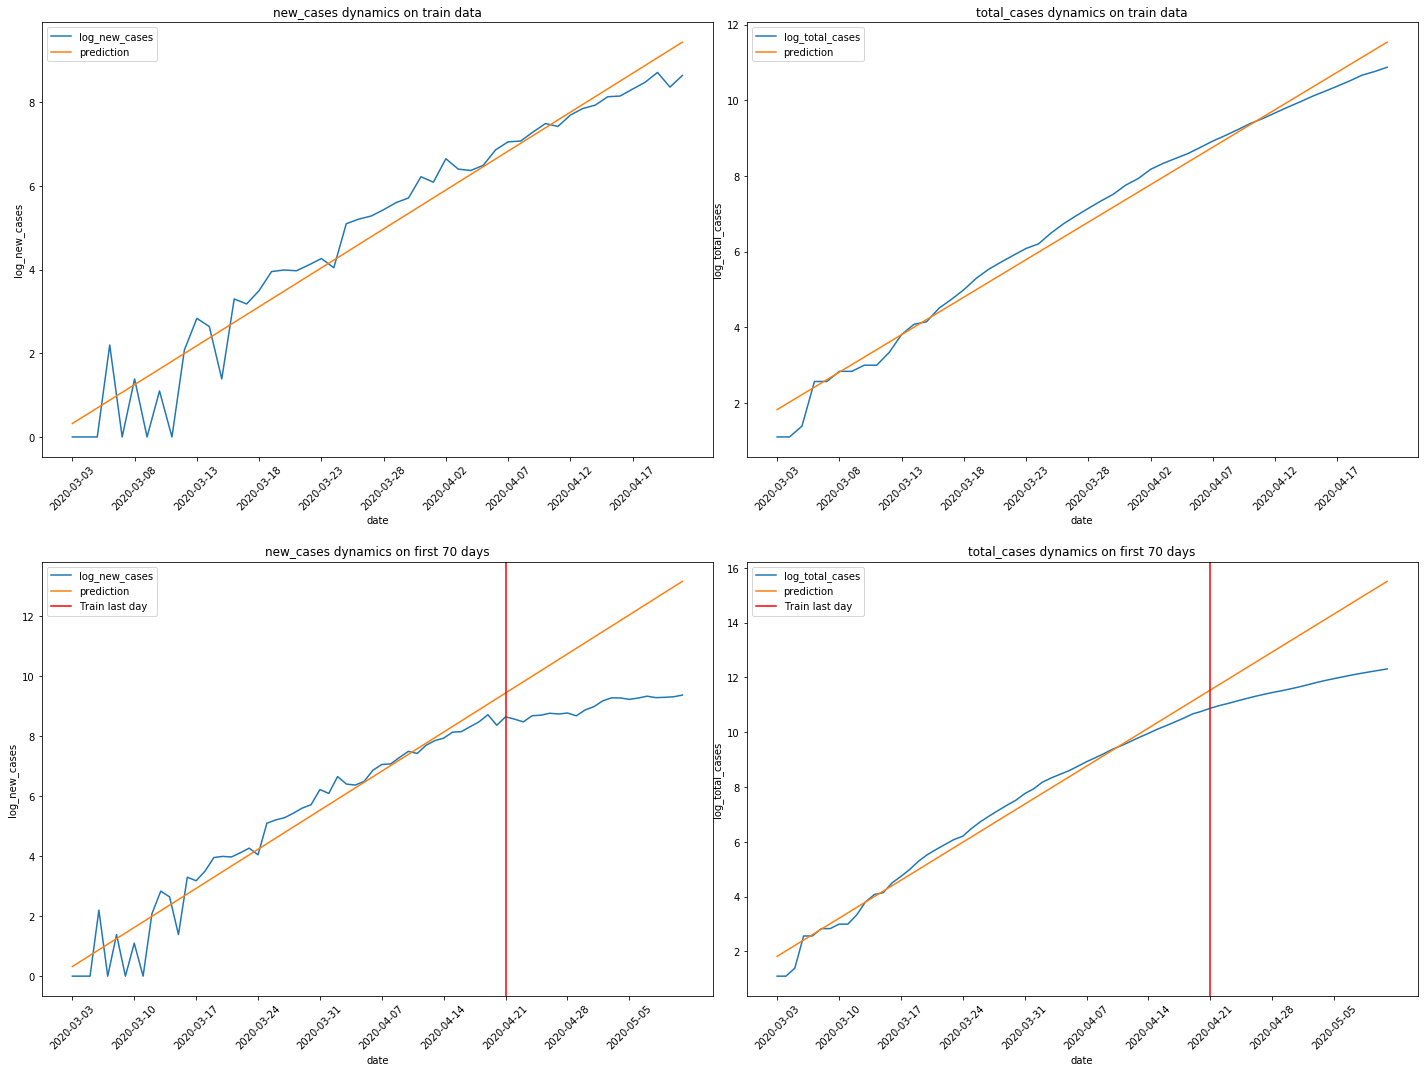

In [17]:
print('График предсказания линейной модели от логарифма таргета')
plt.figure(figsize=(20, 15))

target = 'new_cases'
prediction = f'{target}_prediction'
plt.subplot(2, 2, 1)
plt.tight_layout(pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(f'log_{target}', prediction, df_modeling.query('day_number <= 50'))

plt.subplot(2, 2, 3)
plt.title(f'{target} dynamics on first 70 days')
plot_dynamics(f'log_{target}', prediction, df_modeling, sep_date, 'Train last day')


target = 'total_cases'
prediction = f'{target}_prediction'
plt.subplot(2, 2, 2)
plt.tight_layout(h_pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(f'log_{target}', prediction, df_modeling.query('day_number <= 50'))

plt.subplot(2, 2, 4)
plt.title(f'{target} dynamics on first 70 days')
plot_dynamics(f'log_{target}', prediction, df_modeling, sep_date, 'Train last day')

plt.show()



График экспоненты предсказания линейной модели от таргета


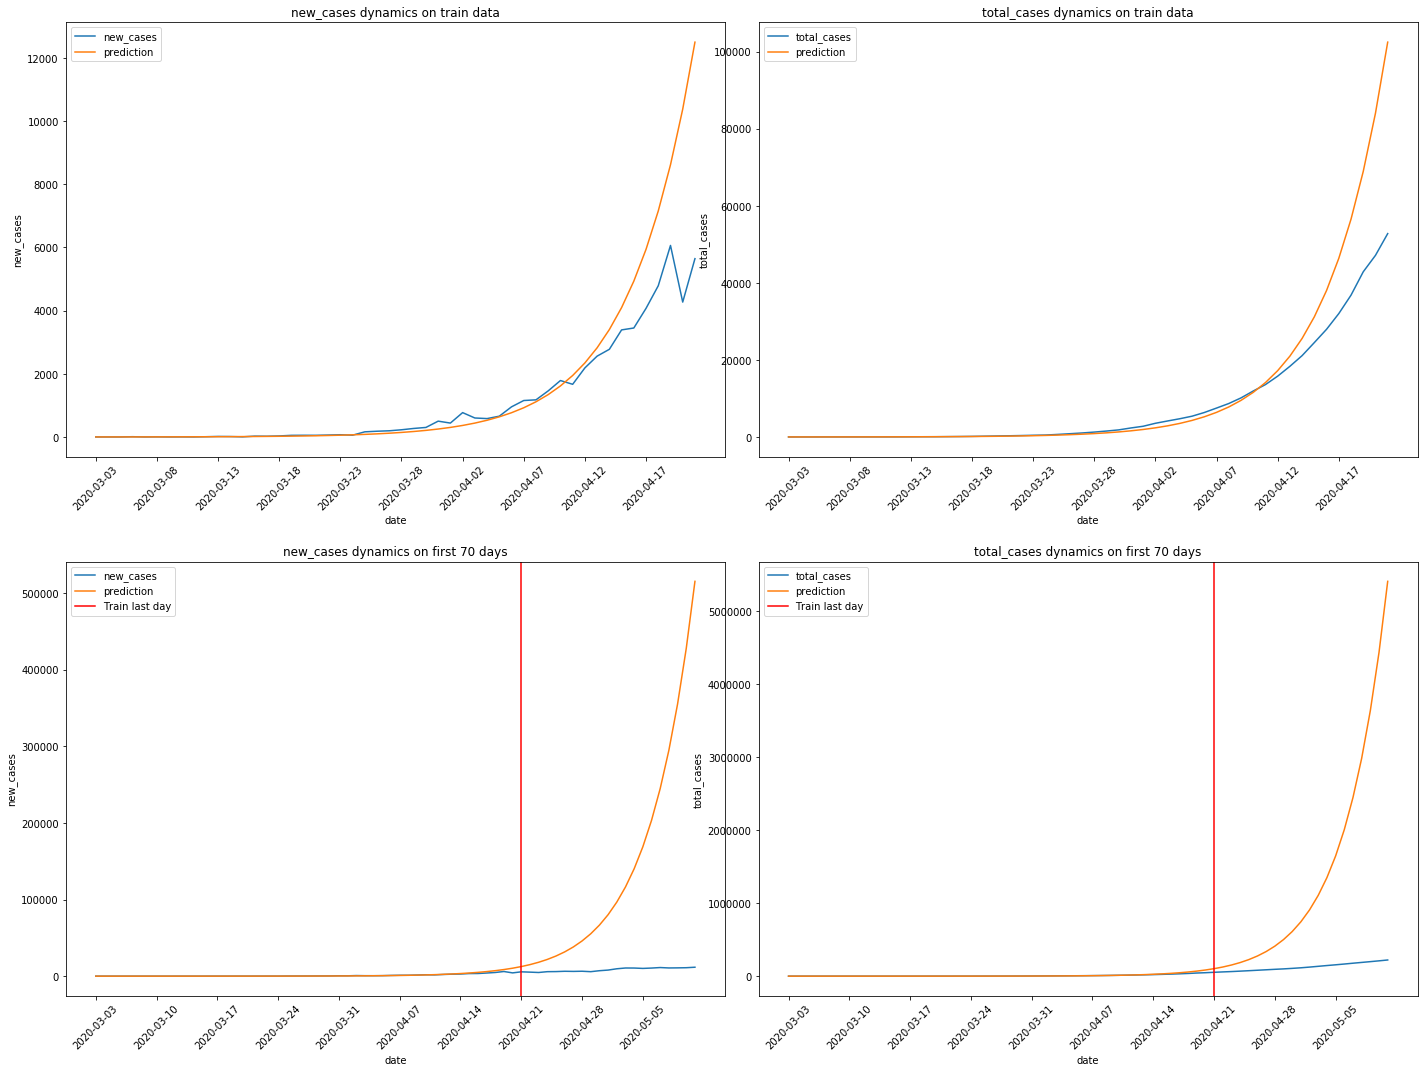

In [18]:
print('График экспоненты предсказания линейной модели от таргета')
plt.figure(figsize=(20, 15))

target = 'new_cases'
prediction = f'exp_{target}_prediction'
plt.subplot(2, 2, 1)
plt.tight_layout(pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(target, prediction, df_modeling.query('day_number <= 50'))

plt.subplot(2, 2, 3)
plt.title(f'{target} dynamics on first 70 days')
plot_dynamics(target, prediction, df_modeling, sep_date, 'Train last day')


target = 'total_cases'
prediction = f'exp_{target}_prediction'
plt.subplot(2, 2, 2)
plt.tight_layout(h_pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(target, prediction, df_modeling.query('day_number <= 50'))

plt.subplot(2, 2, 4)
plt.title(f'{target} dynamics on first 70 days')
plot_dynamics(target, prediction, df_modeling, sep_date, 'Train last day')

plt.show()

Так как мы строили предсказание экспоненты, то на тестовой выборке она начинает существенно отклоняться от верного значения. Это связанно с тем, что рост заболеваемости не экспоненциален и выходит на плато через какое-то время

### Density

#### new_cases

In [115]:
target = 'new_cases'
df_train = df_modeling.query('day_number <= 50')
sigma_noise = mse(df_train[f'log_{target}'], df_train[f'{target}_prediction'])

mu = np.array([0, 0])
sigma = 10000*np.array([[1, 0], [0, 1]])
x = np.column_stack([
    np.ones(df_train.shape[0]),
    df_train[['dne']]
])
y = df_train[f'log_{target}']

# обновление значений мат.ожидания и дисперсии
new_sigma = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x))
new_mu = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))

print(f'Дисперсия шума относительно результатов работы модели {target}: {sigma_noise}')
print(f'Апостериорное распределение параметров модели {target}')
print(f'Мат. ожидание: {new_mu}')
print(f'Дисперсия: {new_sigma}')

Дисперсия шума относительно результатов работы модели new_cases: 0.3553090487811398
Апостериорное распределение параметров модели new_cases
Мат. ожидание: [0.13472429 0.1859631 ]
Дисперсия: [[ 1.04087210e-02 -3.09169931e-04]
 [-3.09169931e-04  1.21243141e-05]]


#### total_cases

In [154]:
target = 'total_cases'
df_train = df_modeling.query('day_number <= 50')
sigma_noise = mse(df_train[f'log_{target}'], df_train[f'{target}_prediction'])

mu = np.array([0, 0])
sigma = 10000*np.array([[1, 0], [0, 1]])
x = np.column_stack([
    np.ones(df_train.shape[0]),
    df_train[['dne']]
])
y = df_train[f'log_{target}']

# обновление значений мат.ожидания и дисперсии
total_sigma = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x))
total_mu = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))

print(f'Дисперсия шума относительно результатов работы модели {target}: {sigma_noise}')
print(f'Апостериорное распределение параметров модели {target}')
print(f'Мат. ожидание: {total_mu}')
print(f'Дисперсия: {total_sigma}')

Дисперсия шума относительно результатов работы модели total_cases: 0.12183046154391235
Апостериорное распределение параметров модели total_cases
Мат. ожидание: [13.799731    1.68656731]
Дисперсия: [[ 1.22376213e-03 -3.63493703e-05]
 [-3.63493703e-05  1.42546554e-06]]


### Exponent sampling

#### new_cases

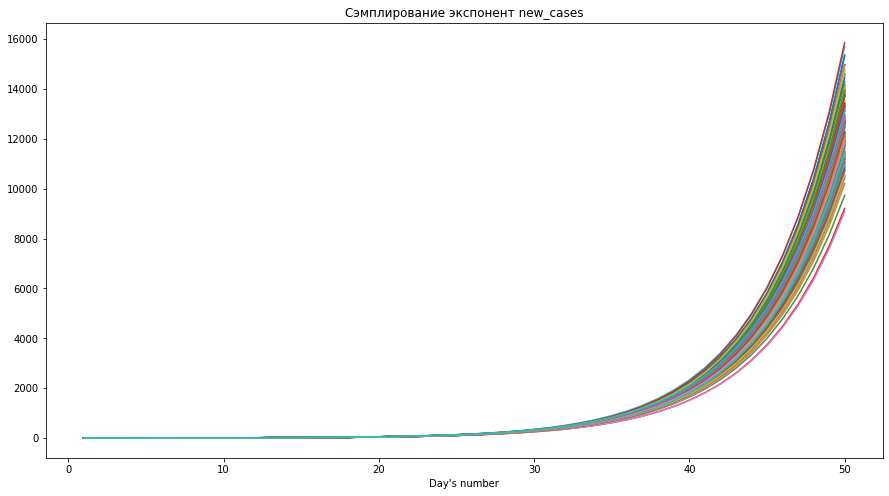

In [138]:
target = 'new_cases'
mu = new_mu
sigma = new_sigma
plt.figure(figsize=(15, 8))
plt.title(f'Сэмплирование экспонент {target}')
#  количество сэмплов 
num = 200
w_list = np.random.multivariate_normal(mu, sigma, num)
for w in w_list:
    plt.plot(x[:,1], np.exp(x @ w))

plt.xlabel("Day's number")
plt.show()

In [150]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
result = []
label = []
for date in dates:
    ans = df_.query('date == @date')
    result.append(ans['day_number'].values[0])
    label.append(ans[target].values[0])

x = np.column_stack([np.ones(len(result)), result])
w = np.random.multivariate_normal(mu, sigma, num)
prediction = np.exp((x @ w.T))

res = {
        'date' : dates,
        'prediction' : np.median(prediction, axis=1).astype(int),
        target : label
}

print(f'Предсказания для таргета {target}')
pd.DataFrame(res)

Предсказания для таргета new_cases


,date,prediction,new_cases
0,2020-05-01,80360,7933.0
1,2020-06-01,25320453,8485.0
2,2020-09-01,695815375078391,4670.0


#### total_cases

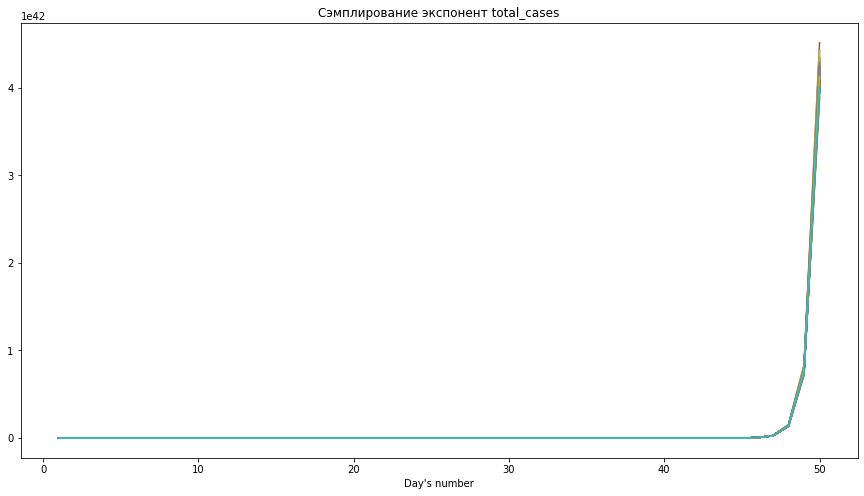

In [155]:
target = 'total_cases'
mu = total_mu
sigma = total_sigma
plt.figure(figsize=(15, 8))
plt.title(f'Сэмплирование экспонент {target}')
#  количество сэмплов 
num = 100
w_list = np.random.multivariate_normal(mu, sigma, num)
for w in w_list:
    plt.plot(x[:,1], np.exp(x @ w))

plt.xlabel("Day's number")
plt.show()

In [157]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
result = []
label = []
for date in dates:
    ans = df_.query('date == @date')
    result.append(ans['day_number'].values[0])
    label.append(ans[target].values[0])

x = np.column_stack([np.ones(len(result)), result])
w = np.random.multivariate_normal(mu, sigma, num)
prediction = np.exp((x @ w.T))

res = {
        'date' : dates,
        'prediction' : np.median(prediction, axis=1),
        target : label
}

print(f'Предсказания для таргета {target}')
pd.DataFrame(res)

Предсказания для таргета total_cases


,date,prediction,total_cases
0,2020-05-01,8.631065e+49,114431.0
1,2020-06-01,4.346598e+72,414328.0
2,2020-09-01,1.021078e+140,997072.0


## Step 3: sigmoid

- Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.
- Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.
- Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?


### Modeling

Для оптимизации параметров сигмоиды предлагается использовать линейную модель, она будет содержать несколько параметров сигмоиды, так как у нас линейная модель от одной переменной, то и количество возможных параметров будет равно 2, поэтому обернем предсказание модели в сигмоиду(y ~ sigmoid(x))


Для работы данного решения будем нормировать таргет от 0 до 1, чтобы не получить логарифм от отрицательного числа

Например, можно брать сигмоиду с константой заведомо больше таргета, например 1e6 для total_cases и 1e5 для new_cases

In [226]:
sigmoid = lambda pred: normalize_const / (1 + np.exp(-pred))
rev_sigmoid = lambda y: np.log(y / (normalize_const - y))

In [200]:
df_modeling = df_.query('day_number <= 70')
df_modeling['dne'] = df_modeling.day_number

In [227]:
# Выбор таргета
target = 'total_cases'
normalize_const = 1e6

# разделение данных на выборки для обучения
tmp = df_modeling.query('day_number <= 50')
X_train, y_train = tmp[['dne']], rev_sigmoid(tmp[target])

tmp = df_modeling.query('day_number > 50')
X_test, y_test = tmp[['dne']], rev_sigmoid(tmp[target])

# Обучение линейной модели
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Предсказание моделей
train_pred = linear_reg.predict(X_train)
test_pred = linear_reg.predict(X_test)

# Вывод результатов
print(f'Target = {target}')
print(f'train MSE: {mse(y_train, train_pred)}')
print(f'test  MSE: {mse(y_test, test_pred)}\n')

print(f'train MAPE: {mape(y_train, train_pred)}')
print(f'test  MAPE: {mape(y_test, test_pred)}\n')


# Сохранение результатов работы модели
df_modeling[f'{target}_prediction'] = list(train_pred) + list(test_pred)

Target = total_cases
train MSE: 0.11706595766542703
test  MSE: 3.824790311993515

train MAPE: 0.0481733444664906
test  MAPE: 1.061845865116106



In [228]:
# Выбор таргета
target = 'new_cases'
normalize_const = 1e5

# разделение данных на выборки для обучения
tmp = df_modeling.query('day_number <= 50')
X_train, y_train = tmp[['dne']], rev_sigmoid(tmp[target])

tmp = df_modeling.query('day_number > 50')
X_test, y_test = tmp[['dne']], rev_sigmoid(tmp[target])


# Обучение линейной модели
linear_reg = LinearRegression(fit_intercept=True)
linear_reg.fit(X_train, y_train)

# Предсказание моделей
train_pred = linear_reg.predict(X_train)
test_pred = linear_reg.predict(X_test)

# Вывод результатов
print(f'Target = {target}')
print(f'train MSE: {mse(y_train, train_pred)}')
print(f'test  MSE: {mse(y_test, test_pred)}\n')

print(f'train MAPE: {mape(y_train, train_pred)}')
print(f'test  MAPE: {mape(y_test, test_pred)}\n')

# Сохранение результатов работы модели
df_modeling[f'{target}_prediction'] = list(train_pred) + list(test_pred)

Target = new_cases
train MSE: 0.34964932560149947
test  MSE: 6.0971266521409335

train MAPE: 0.07289008964036117
test  MAPE: 1.0203583101924398



In [229]:
def plot_dynamics(target: str, prediction: str, df: pd.DataFrame, axline=None, axline_label=None):
    sns.lineplot(data=df,
                 x='date',
                 y=target,
                 label=target)
    sns.lineplot(data=df,
                 x='date',
                 y=prediction,
                 label='prediction')
    if axline:
        plt.axvline(x=axline, label=axline_label, color='red')
    plt.legend()
    plt.xticks(np.arange(0, df.shape[0], step=df.shape[0] // 10), rotation=45)

In [230]:
for target in ['new_cases', 'total_cases']:
    # Расчитываем обратную функцию сигмоиды таргета
    df_modeling[f'log_{target}'] = rev_sigmoid(df_modeling[target])
    # Расчитываем сигмоиду предсказания
    df_modeling[f'exp_{target}_prediction'] = sigmoid(df_modeling[f'{target}_prediction'])

График предсказания линейной модели от логарифма таргета


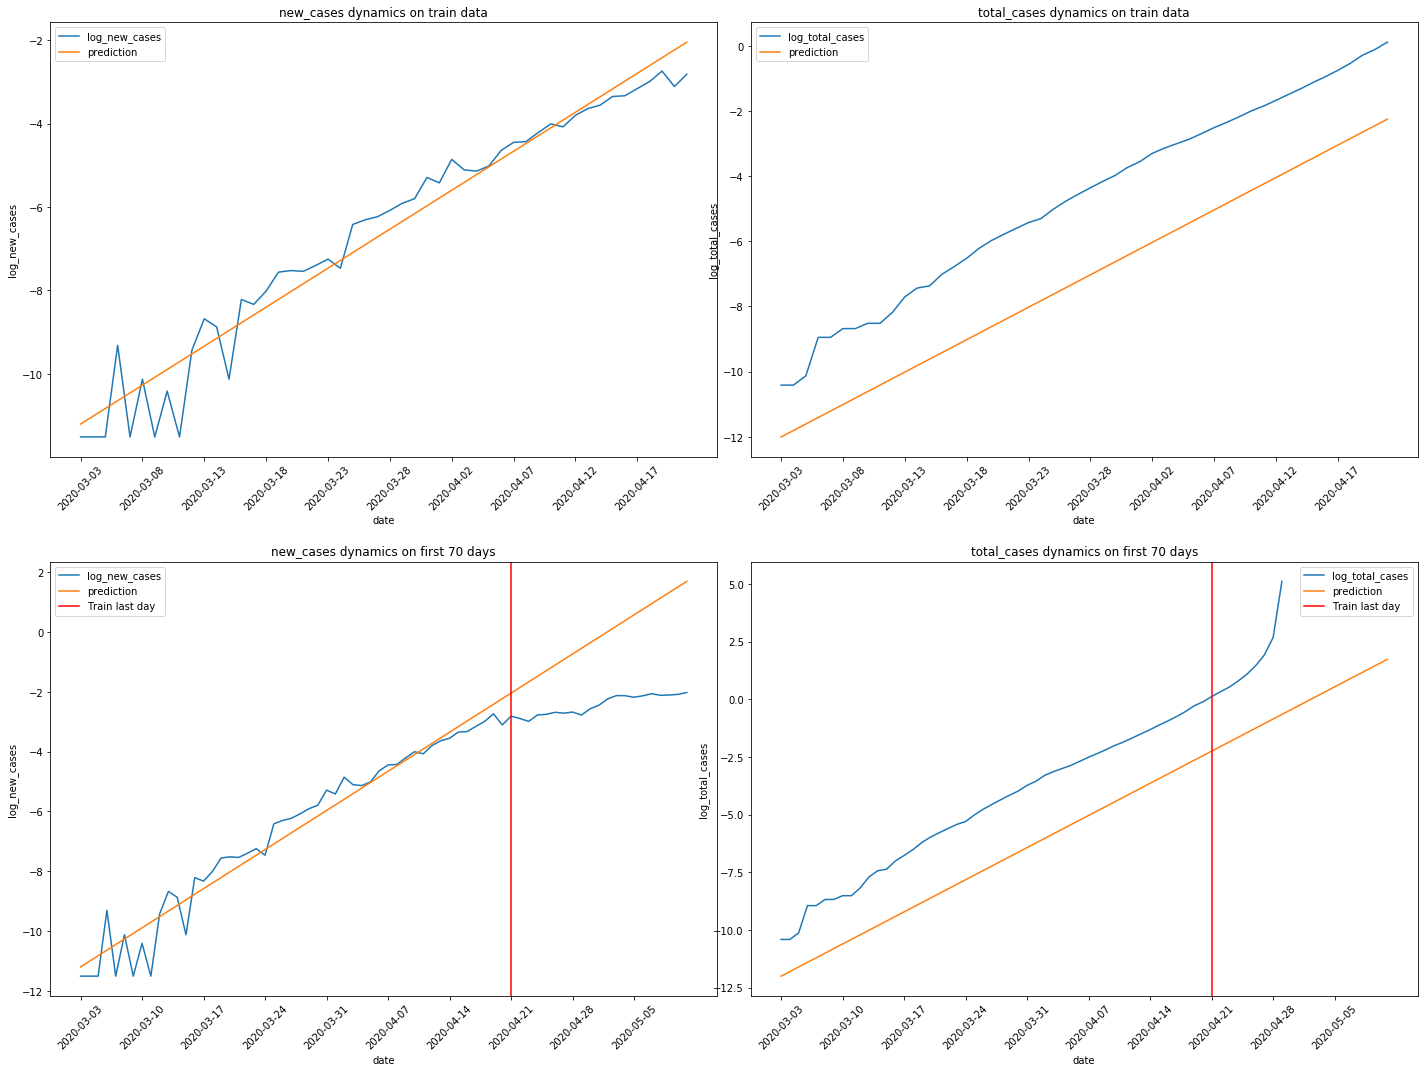

In [231]:
print('График предсказания линейной модели от логарифма таргета')
plt.figure(figsize=(20, 15))

target = 'new_cases'
prediction = f'{target}_prediction'
plt.subplot(2, 2, 1)
plt.tight_layout(pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(f'log_{target}', prediction, df_modeling.query('day_number <= 50'))

plt.subplot(2, 2, 3)
plt.title(f'{target} dynamics on first 70 days')
plot_dynamics(f'log_{target}', prediction, df_modeling, sep_date, 'Train last day')


target = 'total_cases'
prediction = f'{target}_prediction'
plt.subplot(2, 2, 2)
plt.tight_layout(h_pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(f'log_{target}', prediction, df_modeling.query('day_number <= 50'))

plt.subplot(2, 2, 4)
plt.title(f'{target} dynamics on first 70 days')
plot_dynamics(f'log_{target}', prediction, df_modeling, sep_date, 'Train last day')

plt.show()



График сигмоиды предсказания линейной модели от таргета


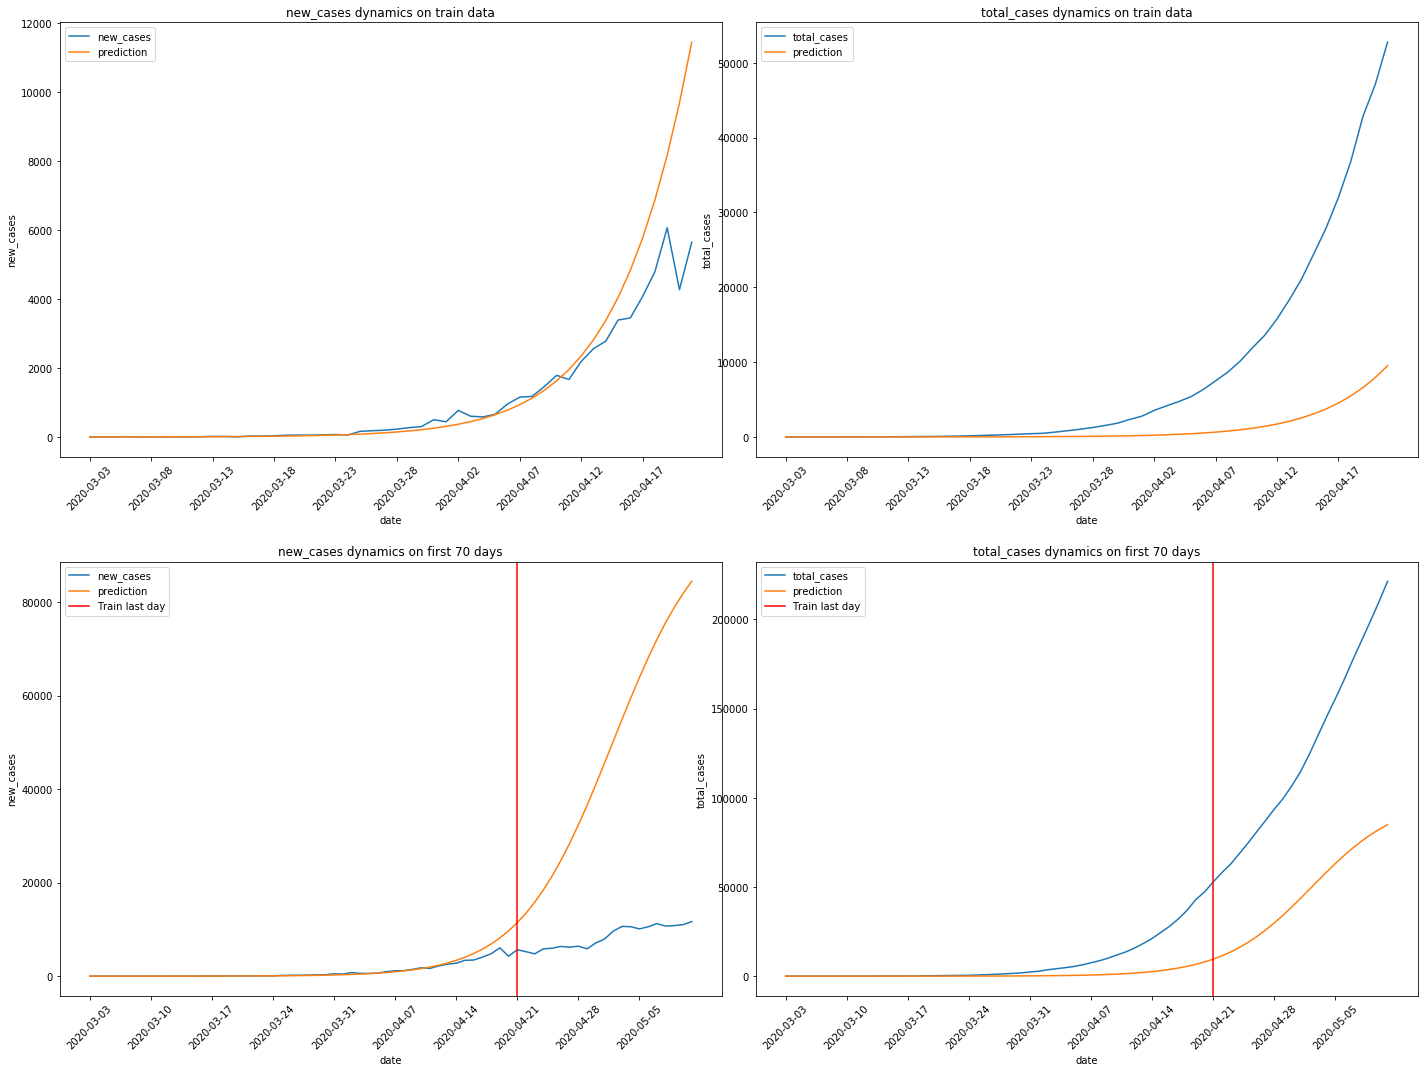

In [232]:
print('График сигмоиды предсказания линейной модели от таргета')
plt.figure(figsize=(20, 15))

target = 'new_cases'
prediction = f'exp_{target}_prediction'
plt.subplot(2, 2, 1)
plt.tight_layout(pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(target, prediction, df_modeling.query('day_number <= 50'))

plt.subplot(2, 2, 3)
plt.title(f'{target} dynamics on first 70 days')
plot_dynamics(target, prediction, df_modeling, sep_date, 'Train last day')


target = 'total_cases'
prediction = f'exp_{target}_prediction'
plt.subplot(2, 2, 2)
plt.tight_layout(h_pad=2)
plt.title(f'{target} dynamics on train data')
plot_dynamics(target, prediction, df_modeling.query('day_number <= 50'))

plt.subplot(2, 2, 4)
plt.title(f'{target} dynamics on first 70 days')
plot_dynamics(target, prediction, df_modeling, sep_date, 'Train last day')

plt.show()

### Density

#### new_cases

In [251]:
target = 'new_cases'
normalize_const = 1e5
df_train = df_modeling.query('day_number <= 50')
sigma_noise = mse(df_train[f'log_{target}'], df_train[f'{target}_prediction'])

mu = np.array([0, 0])
sigma = 10000*np.array([[1, 0], [0, 1]])
x = np.column_stack([
    np.ones(df_train.shape[0]),
    df_train[['dne']]
])
y = df_train[f'log_{target}']

# обновление значений мат.ожидания и дисперсии
new_sigma = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x))
new_mu = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))

print(f'Дисперсия шума относительно результатов работы модели {target}: {sigma_noise}')
print(f'Апостериорное распределение параметров модели {target}')
print(f'Мат. ожидание: {new_mu}')
print(f'Дисперсия: {new_sigma}')

Дисперсия шума относительно результатов работы модели new_cases: 0.34964932560149947
Апостериорное распределение параметров модели new_cases
Мат. ожидание: [-11.76258007   0.19297873]
Дисперсия: [[ 1.00797610e-02 -2.99398843e-04]
 [-2.99398843e-04  1.17411340e-05]]


#### total_cases

In [258]:
target = 'total_cases'
normalize_const = 1e6
df_train = df_modeling.query('day_number <= 50')
sigma_noise = mse(df_train[f'log_{target}'], df_train[f'{target}_prediction'])

mu = np.array([0, 0])
sigma = 10000*np.array([[1, 0], [0, 1]])
x = np.column_stack([
    np.ones(df_train.shape[0]),
    df_train[['dne']]
])
y = df_train[f'log_{target}']

# обновление значений мат.ожидания и дисперсии
total_sigma = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x))
total_mu = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))

print(f'Дисперсия шума относительно результатов работы модели {target}: {sigma_noise}')
print(f'Апостериорное распределение параметров модели {target}')
print(f'Мат. ожидание: {total_mu}')
print(f'Дисперсия: {total_sigma}')

Дисперсия шума относительно результатов работы модели total_cases: 5.815242878008343
Апостериорное распределение параметров модели total_cases
Мат. ожидание: [-0.03741607  0.00077412]
Дисперсия: [[ 2.78740338 -0.08279415]
 [-0.08279415  0.00324705]]


### Exponent sampling

#### new_cases

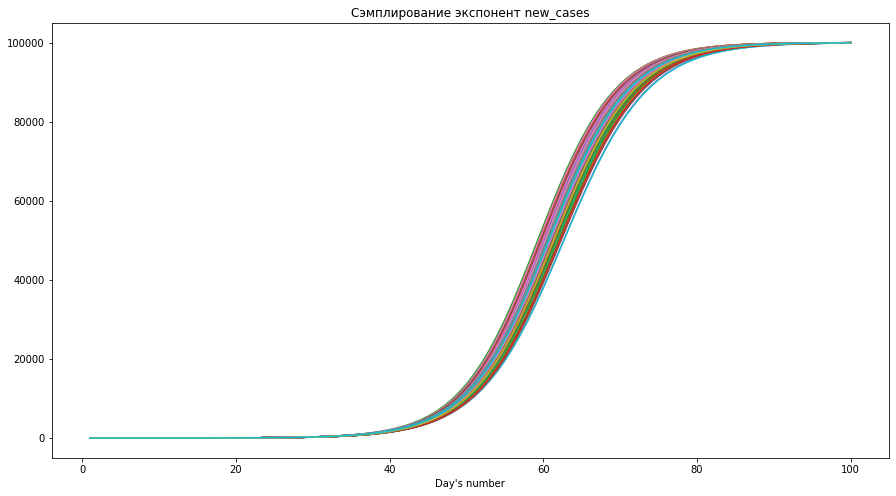

In [262]:
x = np.column_stack([
    np.ones(100),
    [i for i in range(1, 101)]])

target = 'new_cases'
normalize_const = 1e5
mu = new_mu
sigma = new_sigma
plt.figure(figsize=(15, 8))
plt.title(f'Сэмплирование экспонент {target}')
#  количество сэмплов 
num = 200
w_list = np.random.multivariate_normal(mu, sigma, num)
for w in w_list:
    plt.plot(x[:,1], sigmoid(x @ w))

plt.xlabel("Day's number")
plt.show()

In [268]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
result = []
label = []
for date in dates:
    ans = df_.query('date == @date')
    result.append(ans['day_number'].values[0])
    label.append(ans[target].values[0])

x = np.column_stack([np.ones(len(result)), result])
w = np.random.multivariate_normal(mu, sigma, num)
prediction = sigmoid((x @ w.T))

res = {
        'date' : dates,
        'prediction' : np.median(prediction, axis=1).astype(int),
        target : label,
        'quantile_10' : np.quantile(prediction, 0.1, axis=1).astype(int),
        'quantile_90' : np.quantile(prediction, 0.9, axis=1).astype(int)
}

print(f'Предсказания для таргета {target}')
pd.DataFrame(res)

Предсказания для таргета total_cases


,date,prediction,total_cases,quantile_10,quantile_90
0,2020-05-01,619462,114431.0,88799,928367
1,2020-06-01,623947,414328.0,10751,993816
2,2020-09-01,714404,997072.0,25,999992


#### total_cases

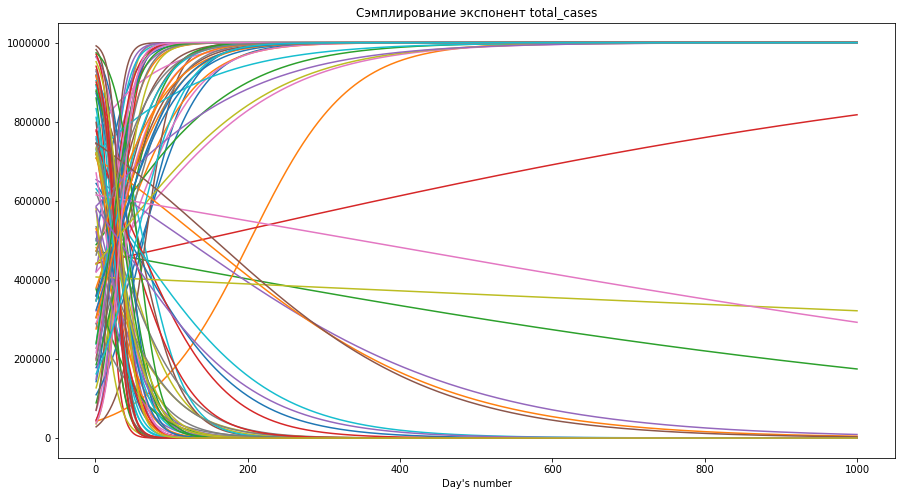

In [266]:
x = np.column_stack([
    np.ones(1000),
    [i for i in range(1, 1001)]])

target = 'total_cases'
normalize_const = 1e6

mu = total_mu
sigma = total_sigma
plt.figure(figsize=(15, 8))
plt.title(f'Сэмплирование экспонент {target}')
#  количество сэмплов 
num = 100
w_list = np.random.multivariate_normal(mu, sigma, num)
for w in w_list:
    plt.plot(x[:,1], sigmoid(x @ w))

plt.xlabel("Day's number")
plt.show()

In [267]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']
result = []
label = []
for date in dates:
    ans = df_.query('date == @date')
    result.append(ans['day_number'].values[0])
    label.append(ans[target].values[0])

x = np.column_stack([np.ones(len(result)), result])
w = np.random.multivariate_normal(mu, sigma, num)
prediction = sigmoid((x @ w.T))

res = {
        'date' : dates,
        'prediction' : np.median(prediction, axis=1),
        target : label,
        'quantile_10' : np.quantile(prediction, 0.1, axis=1).astype(int),
        'quantile_90' : np.quantile(prediction, 0.9, axis=1).astype(int)
}

print(f'Предсказания для таргета {target}')
pd.DataFrame(res)

Предсказания для таргета total_cases


,date,prediction,total_cases,quantile_10,quantile_90
0,2020-05-01,491923.753439,114431.0,83051,933088
1,2020-06-01,449239.715513,414328.0,17493,992223
2,2020-09-01,427310.464378,997072.0,81,999982


Ответы сигмодиды стали больше похожи на правду, но так как использовалось довольно грубая реализация данной функции с помощью линейонй модели, то результаты все равно не идеальны